In [10]:
from __future__ import division, print_function
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import theano
import theano.tensor as T
import lasagne
import math

# Variational Auto-encoders 101

In this exercise we'll implement a variational auto-encoder (VAE). An auto-encoder encodes some input into a new and usually more compact representation which can be used to reconstruct the input data again. A VAE makes the assumption that the compact representation follows a probabilistic distribution (usually Gaussian) which makes it possible to sample new data from a trained variational auto-encoder. The "variational" part of the name comes from the fact that these models are training through variational inference.

The mathematical details of the training can be a bit challenging. However, we believe that probabilistic deep learning will be an important part of future machine learning, which is why we find it important to introduce the concepts.

As background material we recommend reading [Tutorial on Variational Autoencoder](http://arxiv.org/abs/1606.05908). For the implementation of the model you can read the article "Auto-Encoding Variational Bayes", Kingma & Welling, ICLR 2014: http://arxiv.org/pdf/1312.6114v10.pdf and "Stochastic Backpropagation and Approximate Inference in Deep Generative Models", Rezende et al, ICML 2014: http://arxiv.org/pdf/1401.4082v3.pdf.



## VAE crash course

VAEs consist of two parts:

 * Encoder (also known as recognition, inference or Q-model): Maps the input data into a probabilistic latent space by calculating the mean and variance parameters of a Gaussian distribution as a function of the input data x:  $q(z|x) = \mathcal{N}(z|\mu_\theta(x), \sigma_\phi(x)I)$
 * Decoder (also known as generative or P-model): Reconstructs the input data using a sample from the latent space defined by the encoder model: $p(x|z)$
<img src="VAE.png" alt="Drawing" style="width: 300px;"/>


In more mathematical details we have

$p(x) = \int_z p(x|z)p(z)dz$

$p(x) = \int_z p(x|z)p(z)\frac{q(z|x)}{q(z|x)}dz$


$p(x) = \int_z q(z|x) \frac{p(x|z)p(z)}{q(z|x)}dz$


$\log p(x) = \log \int_z q(z|x) \frac{p(x|z)p(z)}{q(z|x)}dz$

The above can be rewritten by applying [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality):

$\log p(x) \geq  \int_z q(z|x)\log \frac{p(x|z)p(z)}{q(z|x)}dz$

This is denoted the variational lower bound. We continue with a bit of rewriting

$\log p(x) \geq E_{q(z|x)} \left[\log \frac{p(x|z)p(z)}{q(z|x)}\right]$

$\log p(x) \geq E_{q(z|x)} \left[\log p(x|z)\right] - KL(q(z|x) || p(z))$

Here the first term on the R.H.S. is the data reconstruction and the second term the Kullback-Leibler divergence between the approximate and true posterior distributions which acts as a probabilistic regularizer.

### Training a VAE 
The VAE is similar to a deterministic autoencoder (lab2) except that we assume that the hidden units follow some distribution. Usually we just assume that the units are independent standard Gaussian distributed.

Above we defined a lower bound on the log-likelihood of the data. We can train the model by pushing up the lowerbound.  By using the _reparameterization trick_ we can directly backprop through the model and optimize the parameters w.r.t. the lower bound.

### Setting up the network

We define the network like an auto-encoder except that the bottle-neck is the __SimpleSampleLayer__ which samples the hidden units. The lower bound is calculated in the ```LogLikelihood``` function. 

## MNIST
First let's load the MNIST dataset and plot a few examples. We only load a limited amount of number classes, so that we can speed up training.

In [11]:
from sklearn.utils import shuffle
#To speed up training we'll only work on a subset of the data
#We discretize the data to 0 and 1 in order to use it with a bernoulli observation model p(x|z) = Ber(mu(z))

def bernoullisample(x):
    return np.random.binomial(1,x,size=x.shape).astype(theano.config.floatX)

data = np.load('../lab1/mnist.npz')
num_classes = 3
idxs_train = []
idxs_valid = []
idxs_test = []
for i in range(num_classes):
    idxs_train += np.where(data['y_train'] == i)[0].tolist()
    idxs_valid += np.where(data['y_valid'] == i)[0].tolist()
    idxs_test += np.where(data['y_test'] == i)[0].tolist()

x_train = bernoullisample(data['X_train'][idxs_train]).astype('float32')
targets_train = data['y_train'][idxs_train].astype('int32') # Since this is unsupervised, the targets are only used for validation.
x_train, targets_train = shuffle(x_train, targets_train, random_state=1234)

x_valid = bernoullisample(data['X_valid'][idxs_valid]).astype('float32')
targets_valid = data['y_valid'][idxs_valid].astype('int32')

x_test = bernoullisample(data['X_test'][idxs_test]).astype('float32')
targets_test = data['y_test'][idxs_test].astype('int32')

print("training set dim(%i, %i)." % x_train.shape)
print("validation set dim(%i, %i)." % x_valid.shape)
print("test set dim(%i, %i)." % x_test.shape)


training set dim(15578, 784).
validation set dim(3045, 784).
test set dim(3147, 784).


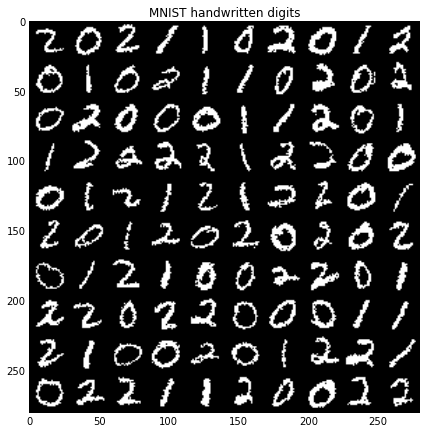

In [12]:
#plot a few MNIST examples
def plot_samples(x,title=''):
    idx = 0
    canvas = np.zeros((28*10, 10*28))
    for i in range(10):
        for j in range(10):
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
            idx += 1
    plt.figure(figsize=(7, 7))
    plt.imshow(canvas, cmap='gray')
    plt.title(title)
    plt.show()

plot_samples(x_train[:100],title='MNIST handwritten digits')

In order to calculate the lower bound, we define following density functions.

In [13]:
#defined a couple of helper functions
c = - 0.5 * math.log(2*math.pi)
def log_bernoulli(x, p, eps=0.0):
    p = T.clip(p, eps, 1.0 - eps)
    return -T.nnet.binary_crossentropy(p, x)

def kl_normal2_stdnormal(mean, log_var):
    return -0.5*(1 + log_var - mean**2 - T.exp(log_var))


### Building the model
When defining the model the latent layer must act as a bottleneck of information, so that we ensure that we find a strong internal representation. We initialize the VAE with 1 hidden layer in the encoder and decoder using relu units as non-linearity.

In [14]:
from lasagne.layers import InputLayer,DenseLayer,get_output, get_all_params
from lasagne.nonlinearities import rectify, sigmoid
from samplelayer import SimpleSampleLayer

num_features = x_train.shape[-1]
num_latent_z = 2

#MODEL SPECIFICATION

#ENCODER
l_in_x = InputLayer(shape=(None, num_features))
l_enc = DenseLayer(l_in_x, num_units=128, nonlinearity=rectify)
l_muq = DenseLayer(l_enc, num_units=num_latent_z, nonlinearity=None)     #mu(x)
l_logvarq = DenseLayer(l_enc, num_units=num_latent_z, nonlinearity=lambda x: T.clip(x,-10,10)) #logvar(x), 
l_z = SimpleSampleLayer(mean=l_muq, log_var=l_logvarq) #sample a latent representation z \sim q(z|x) = N(mu(x),logvar(x))
#we split the in two parts to allow sampling from the decoder model separately
#DECODER
l_in_z = InputLayer(shape=(None, num_latent_z))
l_dec = DenseLayer(l_in_z, num_units=128, nonlinearity=rectify) 
l_mux = DenseLayer(l_dec, num_units=num_features, nonlinearity=sigmoid)  #reconstruction of input using a sigmoid output since mux \in [0,1] 

Following we define the Theano functions for training and evaluation.

In [15]:

sym_x = T.matrix('x')
sym_z = T.matrix('z')

z_train, muq_train, logvarq_train = get_output([l_z,l_muq,l_logvarq],{l_in_x:sym_x},deterministic=False)
mux_train = get_output(l_mux,{l_in_z:z_train},deterministic=False)

z_eval, muq_eval, logvarq_eval = get_output([l_z,l_muq,l_logvarq],{l_in_x:sym_x},deterministic=True)
mux_eval = get_output(l_mux,{l_in_z:z_eval},deterministic=True)

mux_sample = get_output(l_mux,{l_in_z:sym_z},deterministic=True)

#define the cost function
def LogLikelihood(mux,x,muq,logvarq):
    log_px_given_z = log_bernoulli(x, mux, eps=1e-6).sum(axis=1).mean() #note that we sum the latent dimension and mean over the samples
    KL_qp = kl_normal2_stdnormal(muq, logvarq).sum(axis=1).mean()
    LL = log_px_given_z - KL_qp
    return LL, log_px_given_z, KL_qp

LL_train, logpx_train, KL_train = LogLikelihood(mux_train, sym_x, muq_train, logvarq_train)
LL_eval, logpx_eval, KL_eval = LogLikelihood(mux_eval, sym_x, muq_eval, logvarq_eval)

all_params = get_all_params([l_z,l_mux],trainable=True)

# Let Theano do its magic and get all the gradients we need for training
all_grads = T.grad(-LL_train, all_params)

# Set the update function for parameters. The Adam optimizer works really well with VAEs.
updates = lasagne.updates.adam(all_grads, all_params, learning_rate=1e-2)

f_train = theano.function(inputs=[sym_x],
                          outputs=[LL_train, logpx_train, KL_train],
                          updates=updates)

f_eval = theano.function(inputs=[sym_x],
                         outputs=[LL_eval, logpx_eval, KL_eval])

f_z = theano.function(inputs=[sym_x],
                         outputs=[z_eval])

f_sample = theano.function(inputs=[sym_z],
                         outputs=[mux_sample])

f_recon = theano.function(inputs=[sym_x],
                         outputs=[mux_eval])



In the training loop we sample each batch and evaluate the error, latent space and reconstructions every epoch.

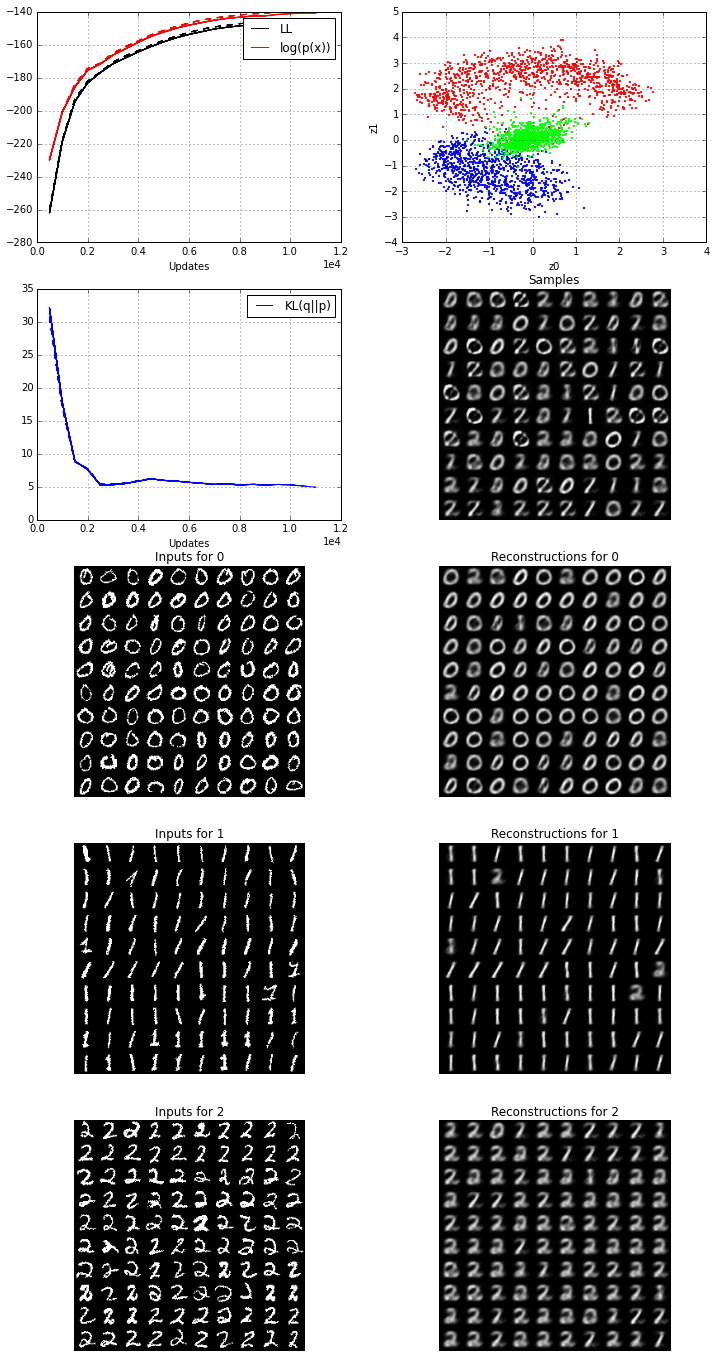

In [16]:
batch_size = 100
samples_to_process = 3e6
val_interval = 5e2
 
LL_train, KL_train, logpx_train = [],[],[]
LL_valid, KL_valid, logpx_valid = [],[],[]
samples_processed = 0
plt.figure(figsize=(12, 24))
valid_samples_processed = []

try:
    while samples_processed < samples_to_process:
        _LL_train, _KL_train, _logpx_train = [],[],[]
        idxs = np.random.choice(range(x_train.shape[0]), size=(batch_size), replace=False)  
        x_batch = x_train[idxs]
        out = f_train(x_batch)
        samples_processed += batch_size
           
        if samples_processed % val_interval == 0:
            valid_samples_processed += [samples_processed]
            out = f_eval(x_train)
            LL_train += [out[0]] 
            logpx_train += [out[1]]
            KL_train += [out[2]]
            
            out = f_eval(x_valid)
            LL_valid += [out[0]]
            logpx_valid += [out[1]]
            KL_valid += [out[2]]
            
            z_eval = f_z(x_valid)[0]
            x_sample = f_sample(np.random.normal(size=(100, num_latent_z)).astype('float32'))[0]
            x_recon = f_recon(x_valid)[0]
            
            plt.subplot(num_classes+2,2,1)
            plt.legend(['LL', 'log(p(x))'])
            plt.xlabel('Updates')
            plt.plot(valid_samples_processed, LL_train, color="black")
            plt.plot(valid_samples_processed, logpx_train, color="red")
            plt.plot(valid_samples_processed, LL_valid, color="black", linestyle="--")
            plt.plot(valid_samples_processed, logpx_valid, color="red", linestyle="--")
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            plt.grid('on')
            
            plt.subplot(num_classes+2,2,2)
            plt.cla()
            plt.xlabel('z0'), plt.ylabel('z1')
            color = iter(plt.get_cmap('brg')(np.linspace(0, 1.0, num_classes)))
            for i in range(num_classes):
                clr = next(color)
                plt.scatter(z_eval[targets_valid==i, 0], z_eval[targets_valid==i, 1], c=clr, s=5., lw=0, marker='o', )
            plt.grid('on')
            
            plt.savefig("out.png")
            display(Image(filename="out.png"))
            clear_output(wait=True)
            
            plt.subplot(num_classes+2,2,3)
            plt.legend(['KL(q||p)'])
            plt.xlabel('Updates')
            plt.plot(valid_samples_processed, KL_train, color="blue")
            plt.plot(valid_samples_processed, KL_valid, color="blue", linestyle="--")
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            plt.grid('on')
            
            plt.subplot(num_classes+2,2,4)
            plt.cla()
            plt.title('Samples')
            plt.axis('off')
            idx = 0
            canvas = np.zeros((28*10, 10*28))
            for i in range(10):
                for j in range(10):
                    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_sample[idx].reshape((28, 28))
                    idx += 1
            plt.imshow(canvas, cmap='gray')
            
            c=0
            for k in range(5, 5 + num_classes*2, 2):
                plt.subplot(num_classes+2,2,k)
                plt.cla()
                plt.title('Inputs for %i' % c)
                plt.axis('off')
                idx = 0
                canvas = np.zeros((28*10, 10*28))
                for i in range(10):
                    for j in range(10):
                        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_valid[targets_valid==c][idx].reshape((28, 28))
                        idx += 1
                plt.imshow(canvas, cmap='gray')

                plt.subplot(num_classes+2,2,k+1)
                plt.cla()
                plt.title('Reconstructions for %i' % c)
                plt.axis('off')
                idx = 0
                canvas = np.zeros((28*10, 10*28))
                for i in range(10):
                    for j in range(10):
                        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_recon[targets_valid==c][idx].reshape((28, 28))
                        idx += 1
                plt.imshow(canvas, cmap='gray')
                c += 1
        
except KeyboardInterrupt:
    pass


### Exercise 1 - Analyzing the VAE
1. The above implementation of a VAE is very simple.
    - *Experiment with the number of layers and non-linearities in order to improve the reconstructions.*
    - *Try to increase the number of digit classes in the training set and analyze the results.*
       
2. Complexity of the bottleneck.
    - *Increase the number of units in the latent layer and train.*
    - *Visualize by using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).*
    
3. Analyzing the KL-term.
    - *Remove the KL-term ($KL \cdot 0$) and analyze what happens to the training.*

4. Use the original paper http://arxiv.org/pdf/1312.6114v10.pdf or [this blog](http://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/) to explain what the reparameterization trick does.

5. The VAE is a probablistic model. We could model $p(x,z,y)$ where $y$ is the label information. Explain how this model could handle semi-supervised learning? You can look through the papers https://arxiv.org/pdf/1406.5298.pdf or  https://arxiv.org/pdf/1602.05473v4.pdf. You'll have to implement this in lab4.

6. Sampling in the VAE.
    - *Explain how one could implement sampling in the VAE and how that would improve learning*.
    - *Look through https://arxiv.org/abs/1509.00519 and explain importance weighted auto-encoders.*
    - *Implement sampling.*


### Exercise 2 - Math intuition (for the ambitious)
1. Use Jensen's inequality to show that, if $q(z|x)\neq 0$,
$$
log p(x) \geq \mathbb{E}_{q(z|x)} \Big [ \log \frac{p(x,z)}{q(z|x)} \Big ]
$$

2. Show that if $\mu_\theta(x)$ and $\sigma_\phi(x)$ are the encoding neural networks with parameters $\theta$ and $\phi$ respectively, taking as input $x$ and

$$
p(z) = \mathcal{N}(z|0,I)\\
q(z|x) = \mathcal{N}(z|\mu_\theta(x), \sigma_\phi(x)I)\\
\mathcal{F}(\theta,\sigma) = \mathbb{E}_{q(z|x)} \Big [ \log \frac{p(x|z)p(z)}{q(z|x)} \Big ]
$$

then

$$
\mathcal{F}(\theta,\sigma) = \mathbb{E}_{\mathcal{N}(\epsilon|0,I)} \Big [ \log \frac{p(x|z)p(z)}{q(z|x)} \Big ] \\
z = \mu_\theta(x) + \sigma_\phi(x) \cdot \epsilon \\
\frac{\partial z}{\partial \theta} = \frac{\partial \mu_\theta(x)}{\partial \theta} \\
\frac{\partial z}{\partial \phi} = \frac{\partial \sigma_\phi(x)}{\partial \phi} \cdot \epsilon
$$